**[MMC-01]**

Import modules.

In [0]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 12

**[MMC-02]**

Define a function to get the maze data in a list.

In [0]:
def get_maze():
  maze_img = '''
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#         G#
############
'''
  maze = []
  for line in maze_img.split('\n'):
    if line == '':
      continue 
    maze.append(list(line))

  return maze

**[MMC-03]**

Define the Agent class to walk through the maze.

In [0]:
class Agent:
  def __init__(self, maze):
    self.maze = maze
    size_y, size_x = len(maze), len(maze[0])
    self.states = [(x, y) for x in range(size_x) for y in range(size_y)]
    self.actions = [(0, -1), (-1, 0), (1, 0), (0, 1)]

    self.policy = {}
    for s in self.states:
      self.policy[s] = self.actions[np.random.randint(len(self.actions))]

    self.q = {}
    self.cnt = {}
    for s in self.states:
      for a in self.actions:
        self.q[(s, a)] = -10**10
        self.cnt[(s, a)] = 0

  def move(self, s, a):
    x, y = s
    dx, dy = a

    if self.maze[y][x] == 'G':
      return 0, s       # Reward, Next state
 
    if self.maze[y+dy][x+dx] != '#':
      x += dx
      y += dy

    return -1, (x, y)   # Reward, Next state

**[MMC-04]**

Define a function to get a single episode.

In [0]:
def get_episode(agent, epsilon):
  episode = []
  s = (1, 1)  # Start

  while True:
    if np.random.random() < epsilon:
      a = agent.actions[np.random.randint(len(agent.actions))]
    else:
      a = agent.policy[s]

    r, s_new = agent.move(s, a)
    episode.append((s, a, r))
    x, y = s_new
    if agent.maze[y][x] == 'G':
      break
    s = s_new

  return episode

**[MMC-05]**

Define a function to update the action policy for a specific state.

In [0]:
def policy_update(agent, s):
  q_max = -10**10
  a_best = None
  for a in agent.actions:
    if agent.q[(s, a)] > q_max:
      q_max = agent.q[(s, a)]
      a_best = a

  agent.policy[s] = a_best

**[MMC-06]**

Define a function to apply the Monte Carlo method with the off-policy data.

In [0]:
def train(agent, epsilon, min_epsilon):
  episode_lengths = []
  max_data_length = 0

  while True:
    episode = get_episode(agent, epsilon)
    episode_lengths.append(len(episode))
    episode.reverse()
    total_r = 0
    last = False
    data_length = 0

    for (s, a, r) in episode:
      data_length += 1

      if a != agent.policy[s]:
        last = True

      total_r += r
      agent.cnt[(s, a)] += 1
      agent.q[(s, a)] += (total_r - agent.q[(s, a)]) / agent.cnt[(s, a)]
      policy_update(agent, s)

      if last:
        break

    epsilon *= 0.999
    if epsilon < min_epsilon:
      break

    if data_length > max_data_length:
      max_data_length = data_length
      result = np.copy(agent.maze)
      for (s, a, r) in episode[:data_length]:
        x, y = s
        result[y][x] = '+'
      print('epsilon={:1.3f}'.format(epsilon))
      for line in result:
        print (''.join(line))
      print ('')

  return episode_lengths

**[MMC-07]**

Get the maze data and create an Agent instance.

In [0]:
maze = get_maze()
agent = Agent(maze)

**[MMC-08]**

Apply the Monte Carlo method to train the agent.

In [0]:
%%time
episode_lengths = train(agent, epsilon=0.9, min_epsilon=0.01)

epsilon=0.899
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#        +G#
############

epsilon=0.897
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#       ++G#
############

epsilon=0.896
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#       ++G#
############

epsilon=0.890
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#      +++G#
############

epsilon=0.885
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#     ++   #
#      +++G#
############

epsilon=0.873
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#     ++   #
#      +++G#
############

epsilon=0.806
############
#S         #
#          #
#######    #
#          #
#          #
#    #######
#          #
#  +++++++G#

**[MMC-09]**

Show the agent path with the trained action policy.

In [0]:
episode = get_episode(agent, epsilon=0)

result = np.copy(agent.maze)
for (s, a, r) in episode:
  x, y = s
  result[y][x] = '+'
for line in result:
  print (''.join(line))

############
#+         #
#+++++++   #
#######+   #
#   ++++   #
#   +      #
#   +#######
#   +++++++#
#         G#
############


**[MMC-10]**

Show the episode lengths during the training.

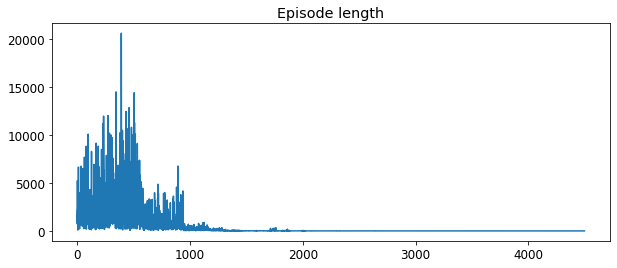

In [0]:
fig = plt.figure(figsize=(10, 4))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_title('Episode length')
subplot.plot(range(len(episode_lengths)), episode_lengths)